In [91]:
import numpy as np
import gym
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

In [92]:
# Create gym environment
env = gym.make('Pendulum-v0')
env.reset()

array([ 0.79058958,  0.6123464 , -0.86190504])

In [93]:
# Neural network model for transition dynamics
# Learns regression from state and action to resulting state and reward
class ControlNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(ControlNet, self).__init__()
        self.input_linear = torch.nn.Linear(input_dim, hidden_dim1)
        self.middle_linear = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.output_linear = torch.nn.Linear(hidden_dim2, output_dim)
    def forward(self, x):
        x = F.relu(self.input_linear(x))
        x = F.relu(self.middle_linear(x))
        x = F.relu(self.output_linear(x))
        return x

In [94]:
# Batch size, input dimension, hidden dimension, output dimension
n, d_in, d_hid1, d_hid2, d_out = 1, 4, 16, 64, 4 
# Instance of nn model
model = ControlNet(d_in, d_hid1, d_hid2, d_out).double()
# Criterion for optimisation: Mean Squared Loss
criterion = torch.nn.MSELoss(reduction='sum') # reduction sum???
# Learning rate for nn
l_rate = 0.01
# Optimizer: Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=l_rate, momentum=0.01)
# Learning episodes
epochs = 1000

In [95]:
# Policy: Random action
def policy(s):
    a = env.action_space.sample()
    return a

Training the network...
... done


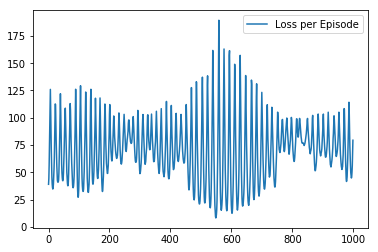

In [96]:
# Training the model
state = env.reset()
plot = []

print("Training the network...")

for epoch in range(epochs):
    # Increase epoch counter
    epoch += 1
    # Render gym environment
    # env.render()
    # Select action according to policy
    action = policy(state)
    # Observations
    old_state = state
    state, reward, done, info = env.step(action)
    
    # Define tensors holding data
    x = Variable(torch.from_numpy(np.array([old_state[0], old_state[1], old_state[2], action])), requires_grad=True)
    y = model.forward(x)
    true_y = Variable(torch.from_numpy(np.array([state[0], state[1], state[2], reward])), requires_grad=True)
    
    
    # Prints
    #print("net input tensor: {} with shape {}".format(net_input,net_input.dim))
    
    
    # Compute loss
    loss = Variable(criterion(true_y, y), requires_grad=True)
    plot.append(loss)
    
    # Clear gradients, backpropagation and weight update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print("... done")

env.close()
# Plot loss
plt.figure()
plt.plot(plot, label="Loss per Episode")
plt.legend()
plt.show()